

This project is designed for seperating fluoroscence and non fluoroscence retinal deposits (presumed amyloid deposits). The main goal is to predict the existance of fluoroscence signal using statistics from polarimetry microscope, allowing amyloid deposits to be detected without the use of a dye.

14 polarization metrics values are considered as input features, 3 machine learning classifiers: LDA, SVM and Random forest have been tested.

We used 3 methods to deal with data imblance:
1. Adding Fluo_Negative_Cross_Negative data by selecting retinal area near deposits
2. ADASYN algorithm
3. BoardlineSMOTE


Author: Yunyi Qiu
Co-author: Tao Jin
Data provided by: Dr.Melanie Campbell's Lab

# Import Data and Basic preparation 

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
from math import pi

# Set precision
pd.options.display.max_columns = None
pd.options.display.max_rows = None
np.set_printoptions(precision=5)

pd.options.display.precision = 5
pd.set_option('precision',5)

axis_font = {'fontname':'Calibri', 'size':20, 'weight':'bold'}

In [2]:
datapath = os.getcwd() + "\\data\\dbt_m.csv"
df = pd.read_csv(datapath)

In [3]:
# Adjust some values in the table
# The Q metric
df[["Q_metric_Background_Mean", "Q_metric_Background_Std", "Q_metric_Deposit_Mean", "Q_metric_Deposit_Std", 
    "Q_metric_Full_Mean", "Q_metric_Full_Std"]] = \
df[["Q_metric_Background_Mean", "Q_metric_Background_Std", "Q_metric_Deposit_Mean", "Q_metric_Deposit_Std", 
    "Q_metric_Full_Mean", "Q_metric_Full_Std"]].divide(3) 

# The Linear retardance
df[["Retardance_Lin_Background_Mean","Retardance_Lin_Background_Std", 
    "Retardance_Lin_Deposit_Mean", "Retardance_Lin_Deposit_Std", 
    "Retardance_Lin_Full_Mean", "Retardance_Lin_Full_Std"]] = \
df[["Retardance_Lin_Background_Mean","Retardance_Lin_Background_Std", 
    "Retardance_Lin_Deposit_Mean", "Retardance_Lin_Deposit_Std", 
    "Retardance_Lin_Full_Mean", "Retardance_Lin_Full_Std"]].divide(180)

# The Circular retardance, Circular diattenuation , Circular polarizance
df[["Retardance_Circ_Background_Mean", "Retardance_Circ_Background_Std", 
    "Retardance_Circ_Deposit_Mean", "Retardance_Circ_Deposit_Std",
    "Retardance_Circ_Full_Mean", "Retardance_Circ_Full_Std"]] = \
(df[["Retardance_Circ_Background_Mean", "Retardance_Circ_Background_Std", 
    "Retardance_Circ_Deposit_Mean", "Retardance_Circ_Deposit_Std",
    "Retardance_Circ_Full_Mean", "Retardance_Circ_Full_Std"]]+ 180).divide(360)

# The Circular diattenuation
df[["Diattenuation_Circ_Background_Mean", "Diattenuation_Circ_Background_Std", 
    "Diattenuation_Circ_Deposit_Mean", "Diattenuation_Circ_Deposit_Std",
    "Diattenuation_Circ_Full_Mean", "Diattenuation_Circ_Full_Std"]] = \
(df[["Diattenuation_Circ_Background_Mean", "Diattenuation_Circ_Background_Std", 
    "Diattenuation_Circ_Deposit_Mean", "Diattenuation_Circ_Deposit_Std",
    "Diattenuation_Circ_Full_Mean", "Diattenuation_Circ_Full_Std"]]+ 1).divide(2)

# The Circular polarizance
df[["Polarizance_Circ_Background_Mean", "Polarizance_Circ_Background_Std", 
    "Polarizance_Circ_Deposit_Mean", "Polarizance_Circ_Deposit_Std",
    "Polarizance_Circ_Full_Mean", "Polarizance_Circ_Full_Std"]] = \
(df[["Polarizance_Circ_Background_Mean", "Polarizance_Circ_Background_Std", 
     "Polarizance_Circ_Deposit_Mean", "Polarizance_Circ_Deposit_Std",
     "Polarizance_Circ_Full_Mean", "Polarizance_Circ_Full_Std"]]+ 1).divide(2)

# The MMT parameters
df[["A_metric_Background_Mean", "A_metric_Background_Std",
    "A_metric_Deposit_Mean", "A_metric_Deposit_Std"]] = \
(df[["A_metric_Background_Mean", "A_metric_Background_Std",
    "A_metric_Deposit_Mean", "A_metric_Deposit_Std"]] + 1).divide(2)

df[["t_metric_Background_Mean", "t_metric_Background_Std",
    "t_metric_Deposit_Mean", "t_metric_Deposit_Std"]] = \
(df[["t_metric_Background_Mean", "t_metric_Background_Std",
    "t_metric_Deposit_Mean", "t_metric_Deposit_Std"]] + 1).divide(2)

df[["x_metric_Background_Mean", "x_metric_Background_Std",
    "x_metric_Deposit_Mean", "x_metric_Deposit_Std"]] = \
(df[["x_metric_Background_Mean", "x_metric_Background_Std",
    "x_metric_Deposit_Mean", "x_metric_Deposit_Std"]] + pi/4).divide(pi/2)

## Prepare data and labels

In [4]:
df_label = df[["RegionFolder", "Subject", "FluoroSignal", "CrossedSignal"]]

In [5]:
# Statistics of the number 
print("  Number of each class \n"
      "  Fluo_Positive_Cross_Positive: " + str(sum(np.multiply(df_label["FluoroSignal"], df_label["CrossedSignal"]))) + "\n" + 
      "  Fluo_Positive_Cross_Negative: " + str(sum(np.multiply(df_label["FluoroSignal"] == 1, df_label["CrossedSignal"] == 0))) + "\n"+
      "  Fluo_Negative_Cross_Positive: " + str(sum(np.multiply(df_label["FluoroSignal"] == 0, df_label["CrossedSignal"] == 1))) + "\n"+
      "  Fluo_Negative_Cross_Negative: " + str(sum(np.multiply(df_label["FluoroSignal"] == 0, df_label["CrossedSignal"] == 0))) + "\n"
     )

  Number of each class 
  Fluo_Positive_Cross_Positive: 789
  Fluo_Positive_Cross_Negative: 20
  Fluo_Negative_Cross_Positive: 131
  Fluo_Negative_Cross_Negative: 7



In [6]:
# df for background

dfb = df[["RegionFolder", "Subject",
          "Depolarization_Power_Background_Mean", "Depolarization_Power_Background_Std", 
          "Q_metric_Background_Mean", "Q_metric_Background_Std",
          "Anisotropy_Lin_Background_Mean", "Anisotropy_Lin_Background_Std",
          "Anisotropy_Circ_Background_Mean", "Anisotropy_Circ_Background_Std",
          "Polarizance_Lin_Background_Mean", "Polarizance_Lin_Background_Std",
          "Polarizance_Circ_Background_Mean", "Polarizance_Circ_Background_Std",
          "Diattenuation_Lin_Background_Mean", "Diattenuation_Lin_Background_Std",
          "Diattenuation_Circ_Background_Mean", "Diattenuation_Circ_Background_Std",
          "Retardance_Lin_Background_Mean", "Retardance_Lin_Background_Std",
          "Retardance_Circ_Background_Mean", "Retardance_Circ_Background_Std",
          "A_metric_Background_Mean", "A_metric_Background_Std",
          "b_metric_Background_Mean", "b_metric_Background_Std",
          "t_metric_Background_Mean", "t_metric_Background_Std",
          "x_metric_Background_Mean", "x_metric_Background_Std",
          "FluoroSignal", "CrossedSignal"
        ]]

dfb.set_index(["RegionFolder", "Subject"], inplace=True)

In [7]:
# df for deposits

dfd = df[["RegionFolder", "Subject",
          "Depolarization_Power_Deposit_Mean", "Depolarization_Power_Deposit_Std", 
          "Q_metric_Deposit_Mean", "Q_metric_Deposit_Std",
          "Anisotropy_Lin_Deposit_Mean", "Anisotropy_Lin_Deposit_Std",
          "Anisotropy_Circ_Deposit_Mean", "Anisotropy_Circ_Deposit_Std",
          "Polarizance_Lin_Deposit_Mean", "Polarizance_Lin_Deposit_Std",
          "Polarizance_Circ_Deposit_Mean", "Polarizance_Circ_Deposit_Std",
          "Diattenuation_Lin_Deposit_Mean", "Diattenuation_Lin_Deposit_Std",
          "Diattenuation_Circ_Deposit_Mean", "Diattenuation_Circ_Deposit_Std",
          "Retardance_Lin_Deposit_Mean", "Retardance_Lin_Deposit_Std",
          "Retardance_Circ_Deposit_Mean", "Retardance_Circ_Deposit_Std",
          "A_metric_Deposit_Mean", "A_metric_Deposit_Std",
          "b_metric_Deposit_Mean", "b_metric_Deposit_Std",
          "t_metric_Deposit_Mean", "t_metric_Deposit_Std",
          "x_metric_Deposit_Mean", "x_metric_Deposit_Std",
          "FluoroSignal", "CrossedSignal"
        ]]
dfd.set_index(["RegionFolder", "Subject"], inplace=True)

# Training using Scikit learn 

In [9]:
# import basic fucntions
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
# Train lda, support vector machine, random forest
from sklearn import svm
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

## Prepare data

In [209]:
# select data_preparation scheme
def data_preparation_scheme(s_num,random_seed):
    if s_num == 1: # train with background data
        dfct = dfd[dfd["CrossedSignal"]==1].copy()
        
        df_b = dfb.sample(n=658, random_state=42)
        
        oldname = ["Depolarization_Power_Background_Mean", "Depolarization_Power_Background_Std", 
                   "Q_metric_Background_Mean", "Q_metric_Background_Std",
                   "Anisotropy_Lin_Background_Mean", "Anisotropy_Lin_Background_Std",
                   "Anisotropy_Circ_Background_Mean", "Anisotropy_Circ_Background_Std",
                   "Polarizance_Lin_Background_Mean", "Polarizance_Lin_Background_Std",
                   "Polarizance_Circ_Background_Mean", "Polarizance_Circ_Background_Std",
                   "Diattenuation_Lin_Background_Mean", "Diattenuation_Lin_Background_Std",
                   "Diattenuation_Circ_Background_Mean", "Diattenuation_Circ_Background_Std",
                   "Retardance_Lin_Background_Mean", "Retardance_Lin_Background_Std",
                   "Retardance_Circ_Background_Mean", "Retardance_Circ_Background_Std",
                   "A_metric_Background_Mean", "A_metric_Background_Std",
                   "b_metric_Background_Mean", "b_metric_Background_Std",
                   "t_metric_Background_Mean", "t_metric_Background_Std",
                   "x_metric_Background_Mean", "x_metric_Background_Std",
                   "FluoroSignal", "CrossedSignal"]
        
        newname = ["Depolarization_Power_Deposit_Mean", "Depolarization_Power_Deposit_Std", 
                   "Q_metric_Deposit_Mean", "Q_metric_Deposit_Std",
                   "Anisotropy_Lin_Deposit_Mean", "Anisotropy_Lin_Deposit_Std",
                   "Anisotropy_Circ_Deposit_Mean", "Anisotropy_Circ_Deposit_Std",
                   "Polarizance_Lin_Deposit_Mean", "Polarizance_Lin_Deposit_Std",
                   "Polarizance_Circ_Deposit_Mean", "Polarizance_Circ_Deposit_Std",
                   "Diattenuation_Lin_Deposit_Mean", "Diattenuation_Lin_Deposit_Std",
                   "Diattenuation_Circ_Deposit_Mean", "Diattenuation_Circ_Deposit_Std",
                   "Retardance_Lin_Deposit_Mean", "Retardance_Lin_Deposit_Std",
                   "Retardance_Circ_Deposit_Mean", "Retardance_Circ_Deposit_Std",
                   "A_metric_Deposit_Mean", "A_metric_Deposit_Std",
                   "b_metric_Deposit_Mean", "b_metric_Deposit_Std",
                   "t_metric_Deposit_Mean", "t_metric_Deposit_Std",
                   "x_metric_Deposit_Mean", "x_metric_Deposit_Std",
                   "FluoroSignal", "CrossedSignal"]
        
        namedict = {oldname[i]: newname[i] for i in range(len(oldname))}
        
        df_b.rename(columns = namedict, inplace=True)
        df_b["FluoroSignal"] = np.zeros(df_b.shape[0], dtype=np.int32)
        df_b["CrossedSignal"] = np.zeros(df_b.shape[0], dtype=np.int32)
        df_r = pd.concat([dfct,df_b])
        
        # prepare data and the labels
        X_r = df_r.values[:,0:(df_r.shape[1]-2)]
        y = df_r["FluoroSignal"].values
        
        # Standardized X
        scaler = preprocessing.StandardScaler().fit(X_r)
        X = scaler.transform(X_r)
        # Split train set and test set
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=random_seed)
        return X_train, X_test, y_train, y_test
    
    if s_num == 2: # train with ADASYN algorithm
        dfct = dfd[dfd["CrossedSignal"]==1].copy()
        metric_data = dfct.values[:,0:(dfct.shape[1]-2)]
        metric_label = dfct["FluoroSignal"].values
        
        ada = ADASYN(random_state=42)
        [ada_data, ada_label] = ada.fit_resample(metric_data,metric_label)
        
        scaler = preprocessing.StandardScaler().fit(ada_data)
        ada_data_ = scaler.transform(ada_data)
        
        X_ada_train, X_ada_test, y_ada_train, y_ada_test = train_test_split(ada_data_, ada_label, test_size=0.2, random_state=random_seed)
        return X_ada_train, X_ada_test, y_ada_train, y_ada_test
    
    if s_num == 3: # train using borderlineSMOTE
        dfct = dfd[dfd["CrossedSignal"]==1].copy()
        metric_data = dfct.values[:,0:(dfct.shape[1]-2)]
        metric_label = dfct["FluoroSignal"].values
        
        BS = BorderlineSMOTE(random_state=42)
        [bs_data, bs_label] = BS.fit_resample(metric_data, metric_label)
        
        scaler = preprocessing.StandardScaler().fit(bs_data)
        bs_data_ = scaler.transform(bs_data)
        
        X_bs_train, X_bs_test, y_bs_train, y_bs_test = train_test_split(bs_data_, bs_label, test_size=0.2, random_state=random_seed)
        return X_bs_train, X_bs_test, y_bs_train, y_bs_test
    
    if s_num == 4: # train without oversampling strategy
        dfct = dfd[dfd["CrossedSignal"]==1].copy()
        metric_data = dfct.values[:,0:(dfct.shape[1]-2)]
        metric_label = dfct["FluoroSignal"].values
        
        X_metric_train, X_metric_test, y_metric_train, y_metric_test = train_test_split(metric_data, metric_label, test_size=0.2, random_state=random_seed)
        return X_metric_train, X_metric_test, y_metric_train, y_metric_test

## Support vector machine 

In [239]:
def train_svm(data_train, label_train):
    wdict_svm = {0: 1, 1: 1}
    clf_svm = svm.SVC(class_weight=wdict_svm,probability=True)
    # optimize the parameters
    param_dist = {"kernel": ["rbf", "poly",'sigmoid'], 
                  "degree": [1, 2, 3],
                  "gamma": [0.001, 0.01, 0.1], 
                  "shrinking": [True, False]
                  }
    n_iter_search = 50
    rs_svm = RandomizedSearchCV(clf_svm, param_distributions=param_dist,
                                      n_iter=n_iter_search, cv=10, n_jobs=-1)
    # train
    rs_svm.fit(data_train, label_train)
    return rs_svm

## Linear discriminant analysis

In [13]:
def train_lda(data_train,label_train):
    clf_lda = lda(store_covariance=True)
    
    # train
    clf_lda.fit(data_train,label_train)
    lda_cv_score = cross_val_score(clf_lda, data_train, label_train, cv=10, scoring="accuracy")
    return clf_lda, lda_cv_score

## Random forest 

In [222]:
def train_rf(data_train, label_train, std=False):
    wdict_rf = {0: 1, 1: 1}
    clf_rf = RandomForestClassifier(n_jobs=-1)
    param_dist = {"n_estimators": sp_randint(100, 1000),
                  "bootstrap": [True, False],
                  "max_features": sp_randint(1, 6) if std else sp_randint(1,4),
                  "min_samples_split": sp_randint(2,3),
                  "criterion": ["gini", "entropy"]}
    n_iter_search = 100
    rs_rf = RandomizedSearchCV(clf_rf, param_distributions=param_dist,
                                      n_iter=n_iter_search, cv=10, n_jobs=-1)    


    
    # train
    rs_rf.fit(data_train, label_train)
    return rs_rf

In [76]:
def train_rf(data_train, label_train, std=False):
    
    wdict_rf = {0: 1, 1: 1}
    clf_rf = RandomForestClassifier(n_jobs=-1,n_estimators=221,max_features=4,criterion="entropy",min_samples_split=2)
    param_dist = {"bootstrap": [True, False]}
    n_iter_search = 2
    rs_rf = RandomizedSearchCV(clf_rf, param_distributions=param_dist,
                                      n_iter=n_iter_search, cv=10, n_jobs=-1)


    
    # train
    rs_rf.fit(data_train, label_train)
    return rs_rf

## Other function

In [15]:
# Define a function for inputing stats from classifier to dataframe
def metric_scores(m_clf,mname, truevalt, predictvalt,LDA=False,lda_cv_score=None):
    
    trueval = truevalt.copy()
    predictval = predictvalt.copy()
    accuracy = accuracy_score(trueval, predictval)
    precision = precision_score(trueval, predictval)
    recall = recall_score(trueval, predictval)
    specificity = recall_score(trueval, predictval, pos_label=0)
    # CV score of the best_estimator
    cvscore = np.mean(lda_cv_score) if LDA else m_clf.best_score_
        
    df_scores = pd.DataFrame({"Method": mname, "Accuracy": [accuracy], "Precision": [precision], "Sensitivity (Recall)": [recall], 
                              "Specificity": [specificity], "Mean accuracy": [cvscore]})
    return df_scores

def train_models(X_train_in, X_test_in, y_train_in, y_test_in,std=False):  
    df_result = pd.DataFrame({"Method": [], "Accuracy": [], "Precision": [], "Sensitivity (Recall)": [], 
                              "Specificity": [], "Mean accuracy": []})
    # lda
    rs_lda_t,lda_cv_score = train_lda(X_train_in, y_train_in)
    y_lda_predict = rs_lda_t.predict(X_test_in)
    df_temp1 = metric_scores(rs_lda_t, "LDA", y_test_in, y_lda_predict,LDA=True,lda_cv_score=lda_cv_score)
    df_result = df_result.append(df_temp1)
    
    # svm
    rs_svm_t = train_svm(X_train_in, y_train_in)
    y_svm_predict = rs_svm_t.predict(X_test_in)
    df_temp2 = metric_scores(rs_svm_t, "SVM", y_test_in, y_svm_predict)
    df_result = df_result.append(df_temp2)
    # rf
    rs_rf_t = train_rf(X_train_in, y_train_in,std=std)
    y_rf_predict = rs_rf_t.predict(X_test_in)    
    df_temp3 = metric_scores(rs_rf_t, "RF", y_test_in, y_rf_predict)
    df_result = df_result.append(df_temp3)
    return df_result, rs_lda_t, y_lda_predict, rs_svm_t, y_svm_predict, rs_rf_t, y_rf_predict

def fimportance_dataframe(name, score):
    feature_importance_table = pd.DataFrame({"Metric": [], "Importance in percentage":[]})
    for name, score in zip(name,score):
        feature_importance_add = pd.DataFrame({"Metric": name, "Importance in percentage":[score]})
        feature_importance_table = feature_importance_table.append(feature_importance_add)
    
    feature_importance_table = feature_importance_table[['Metric','Importance in percentage']]
    feature_importance_table = feature_importance_table.sort_values('Importance in percentage', ascending=False)
    
    return feature_importance_table

# Results 

## Using background data 

The 1st test

In [357]:
X_train_1, X_test_1, y_train_1, y_test_1 = data_preparation_scheme(s_num=1)

b_result_1, b_lda_model_1, b_lda_pred_val_1, b_svm_model_1, b_svm_pred_val_1, b_rf_model_1, b_rf_pred_val_1 = \
                                                train_models(X_train_1, X_test_1, y_train_1,y_test_1)

In [54]:
b_result_1.set_index(["Method"], inplace=True)
b_result_1 

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.93038,0.90964,0.93605,0.93605,0.92361
SVM,0.93671,0.92235,0.93182,0.95349,0.91667
RF,0.93987,0.93502,0.92737,0.96512,0.90972


In [59]:
b_rf_model_1.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 4,
 'min_samples_split': 5,
 'n_estimators': 161}

In [84]:
feature_names = list(dfd.columns[0:-2].values)
feature_names_1 = feature_names[:28]

feature_importance_1 = b_rf_model_1.best_estimator_.feature_importances_
importance_table_1 = fimportance_dataframe(feature_names_1,feature_importance_1)


importance_table_1.set_index(["Metric"])

,Importance in percentage
Metric,
Retardance_Lin_Deposit_Std,0.35419
Anisotropy_Lin_Deposit_Std,0.22956
Retardance_Lin_Deposit_Mean,0.11460
Anisotropy_Lin_Deposit_Mean,0.04970
Q_metric_Deposit_Mean,0.02464
x_metric_Deposit_Mean,0.01750
b_metric_Deposit_Std,0.01487
Diattenuation_Circ_Deposit_Std,0.01384
Polarizance_Circ_Deposit_Std,0.01295


The 2nd test

In [39]:
X_train_2, X_test_2, y_train_2, y_test_2 = data_preparation_scheme(s_num=1)

b_result_2, b_lda_model_2, b_lda_pred_val_2, b_svm_model_2, b_svm_pred_val_2, b_rf_model_2, b_rf_pred_val_2 = \
                                                train_models(X_train_2, X_test_2, y_train_2,y_test_2)

In [40]:
b_result_2.set_index(["Method"], inplace=True)
b_result_2 

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.93038,0.90964,0.93605,0.93605,0.92361
SVM,0.93987,0.92155,0.93220,0.95930,0.91667
RF,0.93354,0.93661,0.91713,0.96512,0.89583


The 3rd test

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = data_preparation_scheme(s_num=1)

b_result_3, b_lda_model_3, b_lda_pred_val_3, b_svm_model_3, b_svm_pred_val_3, b_rf_model_3, b_rf_pred_val_3 = \
                                                train_models(X_train_3, X_test_3, y_train_3,y_test_3)

In [177]:
b_result_3.set_index(["Method"], inplace=True)
b_result_3 

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.92405,0.90891,0.94969,0.90419,0.94631
SVM,0.93354,0.92631,0.91954,0.95808,0.90604
RF,0.93987,0.93661,0.94048,0.94611,0.93289


The 4th test

In [179]:
X_train_4, X_test_4, y_train_4, y_test_4 = data_preparation_scheme(s_num=1)

b_result_4, b_lda_model_4, b_lda_pred_val_4, b_svm_model_4, b_svm_pred_val_4, b_rf_model_4, b_rf_pred_val_4 = \
                                                train_models(X_train_4, X_test_4, y_train_4,y_test_4)

In [180]:
b_result_4.set_index(["Method"], inplace=True)
b_result_4 

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.89873,0.91917,0.91176,0.86111,0.93023
SVM,0.92405,0.92948,0.89474,0.94444,0.90698
RF,0.92722,0.94057,0.90604,0.93750,0.91860


The 5th test

In [182]:
X_train_5, X_test_5, y_train_5, y_test_5 = data_preparation_scheme(s_num=1)

b_result_5, b_lda_model_5, b_lda_pred_val_5, b_svm_model_5, b_svm_pred_val_5, b_rf_model_5, b_rf_pred_val_5 = \
                                                train_models(X_train_5, X_test_5, y_train_5,y_test_5)

In [184]:
b_result_5.set_index(["Method"], inplace=True)
b_result_5 

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.93354,0.90966,0.94805,0.91824,0.94904
SVM,0.94304,0.92314,0.92727,0.96226,0.92357
RF,0.95570,0.93661,0.95031,0.96226,0.94904


### plot ROC curve

In [92]:
b_rf_pred_prob = b_rf_model_2.predict_proba(X_test_2)[:,1]
fpr_b_rf, tpr_b_rf, thresholds_b_rf = roc_curve(y_test_2, b_rf_pred_prob)
auc_b_rf = roc_auc_score(y_test_2,b_rf_pred_prob)
auc_b_rf

0.9742005813953487

In [287]:
b_rf_pred_prob = b_rf_model_3.predict_proba(X_test_3)[:,1]
fpr_b_rf, tpr_b_rf, thresholds_b_rf = roc_curve(y_test_3, b_rf_pred_prob)
auc_b_rf = roc_auc_score(y_test_3,b_rf_pred_prob)
auc_b_rf

0.9875818832134389

In [236]:
b_rf_pred_prob = b_rf_model_4.predict_proba(X_test_4)[:,1]
fpr_b_rf, tpr_b_rf, thresholds_b_rf = roc_curve(y_test_4, b_rf_pred_prob)
auc_b_rf = roc_auc_score(y_test_4,b_rf_pred_prob)
auc_b_rf

0.9773094315245477

In [237]:
b_rf_pred_prob = b_rf_model_5.predict_proba(X_test_5)[:,1]
fpr_b_rf, tpr_b_rf, thresholds_b_rf = roc_curve(y_test_5, b_rf_pred_prob)
auc_b_rf = roc_auc_score(y_test_5,b_rf_pred_prob)
auc_b_rf

0.9847774706565717

In [152]:
fpr_b_rf.shape

(60,)

In [100]:
b_svm_pred_prob = b_svm_model_2.predict_proba(X_test_2)[:,1]
fpr_b_svm, tpr_b_svm, thresholds_b_svm = roc_curve(y_test_2, b_svm_pred_prob)
auc_b_svm = roc_auc_score(y_test_2,b_svm_pred_prob)
auc_b_svm

0.9573643410852712

In [288]:
b_svm_pred_prob = b_svm_model_4.predict_proba(X_test_4)[:,1]
fpr_b_svm, tpr_b_svm, thresholds_b_svm = roc_curve(y_test_4, b_svm_pred_prob)
auc_b_svm = roc_auc_score(y_test_4,b_svm_pred_prob)
auc_b_svm

0.9730297157622739

In [245]:
b_svm_pred_prob = b_svm_model_5.predict_proba(X_test_5)[:,1]
fpr_b_svm, tpr_b_svm, thresholds_b_svm = roc_curve(y_test_5, b_svm_pred_prob)
auc_b_svm = roc_auc_score(y_test_5,b_svm_pred_prob)
auc_b_svm

0.976164723791211

In [252]:
b_svm_pred_prob = b_svm_model_5.predict_proba(X_test_2)[:,1]
fpr_b_svm, tpr_b_svm, thresholds_b_svm = roc_curve(y_test_2, b_svm_pred_prob)
auc_b_svm = roc_auc_score(y_test_2,b_svm_pred_prob)
auc_b_svm

0.9840923772609819

In [289]:
b_lda_pred_prob = b_lda_model_2.predict_proba(X_test_2)[:,1]
fpr_b_lda, tpr_b_lda, thresholds_b_lda = roc_curve(y_test_2, b_lda_pred_prob)
auc_b_lda = roc_auc_score(y_test_2,b_lda_pred_prob)
auc_b_lda

0.9562742248062015

In [253]:
b_lda_pred_prob = b_lda_model_3.predict_proba(X_test_3)[:,1]
fpr_b_lda, tpr_b_lda, thresholds_b_lda = roc_curve(y_test_3, b_lda_pred_prob)
auc_b_lda = roc_auc_score(y_test_3,b_lda_pred_prob)
auc_b_lda

0.9755254591488164

In [254]:
b_lda_pred_prob = b_lda_model_4.predict_proba(X_test_4)[:,1]
fpr_b_lda, tpr_b_lda, thresholds_b_lda = roc_curve(y_test_4, b_lda_pred_prob)
auc_b_lda = roc_auc_score(y_test_4,b_lda_pred_prob)
auc_b_lda

0.9628956718346253

In [256]:
b_lda_pred_prob = b_lda_model_5.predict_proba(X_test_5)[:,1]
fpr_b_lda, tpr_b_lda, thresholds_b_lda = roc_curve(y_test_5, b_lda_pred_prob)
auc_b_lda = roc_auc_score(y_test_5,b_lda_pred_prob)
auc_b_lda

0.9796498818251012

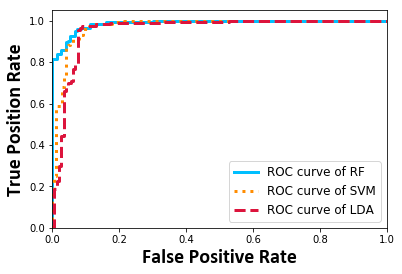

In [290]:
plt.figure()
plt.plot(fpr_b_rf,tpr_b_rf,'deepskyblue',label='ROC curve of RF',linewidth=3)
plt.plot(fpr_b_svm,tpr_b_svm,'darkorange',label='ROC curve of SVM',linewidth=3,linestyle=':')
plt.plot(fpr_b_lda,tpr_b_lda,'crimson',label='ROC curve of LDA',linewidth=3,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',**axis_font)
plt.ylabel('True Position Rate',**axis_font)
plt.legend(loc='lower right',fontsize=12)
plt.savefig('ROC_retina_sampling',dpi=1200)
plt.show()

### Save variable 

In [276]:
importance_table_1.to_csv(os.getcwd() + "\\data\\FItable1.csv")

In [159]:
import scipy.io as sio

In [349]:
sio.savemat("X_b.mat", mdict={'X':np.concatenate((X_train_1,X_test_1))})
sio.savemat("y_b.mat", mdict={'y':np.concatenate((y_train_1,y_test_1))})

In [167]:
X_train_BS, X_test_BS, y_train_BS, y_test_BS = data_preparation_scheme(s_num=3)

sio.savemat("X_BS.mat", mdict={'X':np.concatenate((X_train_BS,X_test_BS))})
sio.savemat("y_BS.mat", mdict={'y':np.concatenate((y_train_BS,y_test_BS))})

In [ ]:
dfct = dfd[dfd["CrossedSignal"]==1].copy()
metric_data = dfct.values[:,0:(dfct.shape[1]-2)]
metric_label = dfct["FluoroSignal"].values

BS = BorderlineSMOTE(random_state=42, kind='borderline-2')
[bs_data, bs_label] = BS.fit_resample(metric_data, metric_label)

#scaler = preprocessing.StandardScaler().fit(bs_data)
#bs_data_ = scaler.transform(bs_data)

X_bs_train, X_bs_test, y_bs_train, y_bs_test = train_test_split(bs_data, bs_label, test_size=0.2, random_state=42)

### After random forest selection 

In [213]:
selected_metrics = importance_table_1[importance_table_1.loc[:,'Importance in percentage'] > 0.01]["Metric"].values

In [214]:
selected_metrics

array(['Retardance_Lin_Deposit_Std', 'Anisotropy_Lin_Deposit_Std',
       'Retardance_Lin_Deposit_Mean', 'Anisotropy_Lin_Deposit_Mean',
       'Q_metric_Deposit_Mean', 'x_metric_Deposit_Mean',
       'b_metric_Deposit_Std', 'Diattenuation_Circ_Deposit_Std',
       'Polarizance_Circ_Deposit_Std', 'Q_metric_Deposit_Std',
       'Depolarization_Power_Deposit_Mean',
       'Depolarization_Power_Deposit_Std', 't_metric_Deposit_Std',
       'Diattenuation_Circ_Deposit_Mean', 'Diattenuation_Lin_Deposit_Std',
       'Polarizance_Circ_Deposit_Mean'], dtype=object)

In [215]:
len(selected_metrics)

16

In [216]:
dfd_1_selected = df[selected_metrics.tolist() + ["FluoroSignal", "CrossedSignal"]]

selected_metrics_background = [metric.replace('Deposit','Background') for metric in selected_metrics]
dfb_1_selected = df[selected_metrics_background + ["FluoroSignal", "CrossedSignal"]]

In [217]:
def new_preparation_background():
    dfct = dfd_1_selected[dfd_1_selected["CrossedSignal"]==1].copy()  
    
    df_b = dfb_1_selected.sample(n=658, random_state=42)
    oldname = df_b.columns.tolist()
    newname = selected_metrics.tolist() + ["FluoroSignal", "CrossedSignal"]
    namedict = {oldname[i]: newname[i] for i in range(len(oldname))}
    df_b.rename(columns=namedict, inplace=True)
    
    df_b["FluoroSignal"] = np.zeros(df_b.shape[0], dtype=np.int32)
    df_b["CrossedSignal"] = np.zeros(df_b.shape[0], dtype=np.int32)
    
    df_r = pd.concat([dfct,df_b])
        
    # prepare data and the labels
    X_r = df_r.values[:,0:(df_r.shape[1]-2)]
    y = df_r["FluoroSignal"].values
        
    # Standardized X
    scaler = preprocessing.StandardScaler().fit(X_r)
    X = scaler.transform(X_r)
    # Split train set and test set
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [218]:
X_train_selected, X_test_selected, y_train_selected, y_test_selected = new_preparation_background()

b_result_selected, b_lda_model_selected, b_lda_pred_val_selected, b_svm_model_selected, b_svm_pred_val_selected, b_rf_model_selected, b_rf_pred_val_selected = \
                                                train_models(X_train_selected, X_test_selected, y_train_selected,y_test_selected)

In [219]:
b_result_selected.set_index(["Method"], inplace=True)
b_result_selected 

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.92405,0.90173,0.93023,0.93023,0.91667
SVM,0.93038,0.91838,0.92614,0.94767,0.90972
RF,0.93671,0.93582,0.91758,0.97093,0.89583


### Using only linear anisotropy and linear retardance 

In [220]:
def LA_LR_scheme(random_seed):
    dfct = dfd[dfd["CrossedSignal"]==1].copy()
        
    df_b = dfb.sample(n=658, random_state=42)
        
    oldname = [ "Anisotropy_Lin_Background_Mean", "Anisotropy_Lin_Background_Std",
                "Retardance_Lin_Background_Mean", "Retardance_Lin_Background_Std",
                "FluoroSignal", "CrossedSignal"]
        
    newname = ["Anisotropy_Lin_Deposit_Mean", "Anisotropy_Lin_Deposit_Std",
               "Retardance_Lin_Deposit_Mean", "Retardance_Lin_Deposit_Std",
               "FluoroSignal", "CrossedSignal"]
    
    dfct = dfct[newname]
    df_b = df_b[oldname]
    
    namedict = {oldname[i]: newname[i] for i in range(len(oldname))}

    df_b.rename(columns = namedict, inplace=True)
    df_b["FluoroSignal"] = np.zeros(df_b.shape[0], dtype=np.int32)
    df_b["CrossedSignal"] = np.zeros(df_b.shape[0], dtype=np.int32)
    df_r = pd.concat([dfct,df_b])

    # prepare data and the labels
    X_r = df_r.values[:,0:(df_r.shape[1]-2)]
    y = df_r["FluoroSignal"].values

    # Standardized X
    scaler = preprocessing.StandardScaler().fit(X_r)
    X = scaler.transform(X_r)
    # Split train set and test set
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=random_seed)
    return X_train, X_test, y_train, y_test

In [310]:
X_train_LA_LR, X_test_LA_LR, y_train_LA_LR, y_test_LA_LR = LA_LR_scheme()

b_result_LA_LR, b_lda_model_LA_LR, b_lda_pred_val_LA_LR, b_svm_model_LA_LR, b_svm_pred_val_LA_LR, b_rf_model_LA_LR, b_rf_pred_val_LA_LR = \
                                                train_models(X_train_LA_LR, X_test_LA_LR, y_train_LA_LR,y_test_LA_LR)

In [311]:
b_result_LA_LR.set_index(["Method"], inplace=True)
b_result_LA_LR 

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.88924,0.89068,0.92547,0.86628,0.91667
SVM,0.92722,0.92472,0.91620,0.95349,0.89583
RF,0.92089,0.92868,0.91525,0.94186,0.89583


In [313]:
feature_importance_LA_LR = b_rf_model_LA_LR.best_estimator_.feature_importances_
feature_importance_LA_LR

array([0.20089, 0.26602, 0.25356, 0.27953])

In [223]:
X_train_LA_LR2, X_test_LA_LR2, y_train_LA_LR2, y_test_LA_LR2 = LA_LR_scheme(1)

b_result_LA_LR2, b_lda_model_LA_LR2, b_lda_pred_val_LA_LR2, b_svm_model_LA_LR2, b_svm_pred_val_LA_LR2, b_rf_model_LA_LR2, b_rf_pred_val_LA_LR2 = \
                                                train_models(X_train_LA_LR2, X_test_LA_LR2, y_train_LA_LR2,y_test_LA_LR2)

In [224]:
b_result_LA_LR2.set_index(["Method"], inplace=True)
b_result_LA_LR2 

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.89241,0.89304,0.95862,0.83234,0.95973
SVM,0.93671,0.92393,0.93491,0.94611,0.92617
RF,0.93038,0.92631,0.91429,0.95808,0.89933


In [225]:
X_train_LA_LR3, X_test_LA_LR3, y_train_LA_LR3, y_test_LA_LR3 = LA_LR_scheme(10)

b_result_LA_LR3, b_lda_model_LA_LR3, b_lda_pred_val_LA_LR3, b_svm_model_LA_LR3, b_svm_pred_val_LA_LR3, b_rf_model_LA_LR3, b_rf_pred_val_LA_LR3 = \
                                                train_models(X_train_LA_LR3, X_test_LA_LR3, y_train_LA_LR3,y_test_LA_LR3)

In [231]:
b_result_LA_LR3.set_index(["Method"], inplace=True)
b_result_LA_LR3 

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.87658,0.89620,0.92683,0.79167,0.94767
SVM,0.91456,0.92948,0.89262,0.92361,0.90698
RF,0.92089,0.93740,0.88387,0.95139,0.89535


In [226]:
X_train_LA_LR4, X_test_LA_LR4, y_train_LA_LR4, y_test_LA_LR4 = LA_LR_scheme(15)

b_result_LA_LR4, b_lda_model_LA_LR4, b_lda_pred_val_LA_LR4, b_svm_model_LA_LR4, b_svm_pred_val_LA_LR4, b_rf_model_LA_LR4, b_rf_pred_val_LA_LR4 = \
                                                train_models(X_train_LA_LR4, X_test_LA_LR4, y_train_LA_LR4,y_test_LA_LR4)

In [227]:
b_result_LA_LR4.set_index(["Method"], inplace=True)
b_result_LA_LR4 

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.90823,0.88824,0.94521,0.86792,0.94904
SVM,0.93038,0.92076,0.93631,0.92453,0.93631
RF,0.94304,0.92472,0.94340,0.94340,0.94268


In [228]:
X_train_LA_LR5, X_test_LA_LR5, y_train_LA_LR5, y_test_LA_LR5 = LA_LR_scheme(20)

b_result_LA_LR5, b_lda_model_LA_LR5, b_lda_pred_val_LA_LR5, b_svm_model_LA_LR5, b_svm_pred_val_LA_LR5, b_rf_model_LA_LR5, b_rf_pred_val_LA_LR5 = \
                                                train_models(X_train_LA_LR5, X_test_LA_LR5, y_train_LA_LR5,y_test_LA_LR5)

In [302]:
#b_result_LA_LR5.set_index(["Method"], inplace=True)
b_result_LA_LR5 

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.90823,0.88824,0.94521,0.86792,0.94904
SVM,0.94620,0.92076,0.94375,0.94969,0.94268
RF,0.94304,0.92472,0.93789,0.94969,0.93631


## Using ADASYN

In [71]:
X_train_ada, X_test_ada, y_train_ada, y_test_ada = data_preparation_scheme(s_num=2)

ada_result_1, ada_lda_model_1, ada_lda_pred_val_1, ada_svm_model_1, ada_svm_pred_val_1, ada_rf_model_1, ada_rf_pred_val_1 = \
                                                train_models(X_train_ada, X_test_ada, y_train_ada,y_test_ada)

In [76]:
ada_result_1.set_index(["Method"], inplace=True)
ada_result_1

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.76972,0.76730,0.81818,0.68790,0.85000
SVM,0.92744,0.93829,0.88953,0.97452,0.88125
RF,0.90221,0.93592,0.91447,0.88535,0.91875


In [167]:
ada_rf_model_1.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 6,
 'min_samples_split': 3,
 'n_estimators': 727}

In [220]:
feature_names = list(dfd.columns[0:-2].values)
feature_names_2 = feature_names[:28]

feature_importance_2 = ada_rf_model_1.best_estimator_.feature_importances_
importance_table_2 = fimportance_dataframe(feature_names_2,feature_importance_2)

importance_table_2.set_index(["Metric"])

,Importance in percentage
Metric,
x_metric_Deposit_Mean,0.08745
Retardance_Lin_Deposit_Std,0.08552
Diattenuation_Circ_Deposit_Std,0.08035
Retardance_Lin_Deposit_Mean,0.06285
Polarizance_Circ_Deposit_Std,0.05558
Anisotropy_Lin_Deposit_Std,0.04126
Anisotropy_Lin_Deposit_Mean,0.03851
Retardance_Circ_Deposit_Std,0.03825
Q_metric_Deposit_Mean,0.03432


## Using borderlineSMOTE 

The 1st test

In [80]:
X_train_BS, X_test_BS, y_train_BS, y_test_BS = data_preparation_scheme(s_num=3)

BS_result_1, BS_lda_model_1, BS_lda_pred_val_1, BS_svm_model_1, BS_svm_pred_val_1, BS_rf_model_1, BS_rf_pred_val_1 = \
                                                train_models(X_train_BS, X_test_BS, y_train_BS,y_test_BS)

In [233]:
import collections
collections.Counter(np.append(y_train_BS,y_test_BS))

Counter({0: 789, 1: 789})

In [259]:
BS_result_1.set_index(["Method"], inplace=True)
BS_result_1

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.78165,0.79242,0.83226,0.75000,0.81944
SVM,0.92405,0.92393,0.94578,0.91279,0.93750
RF,0.93354,0.93185,0.93642,0.94186,0.92361


In [260]:
BS_rf_model_1.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_features': 4,
 'min_samples_split': 2,
 'n_estimators': 101}

In [264]:
feature_names = list(dfd.columns[0:-2].values)
feature_names_3 = feature_names[:28]

feature_importance_3 = BS_rf_model_1.best_estimator_.feature_importances_
importance_table_3 = fimportance_dataframe(feature_names_3,feature_importance_3)

importance_table_3.set_index(["Metric"])

,Importance in percentage
Metric,
x_metric_Deposit_Mean,0.10079
Retardance_Lin_Deposit_Std,0.07078
Retardance_Circ_Deposit_Mean,0.06237
A_metric_Deposit_Std,0.05247
Diattenuation_Circ_Deposit_Std,0.04982
Anisotropy_Lin_Deposit_Mean,0.04956
Q_metric_Deposit_Std,0.04311
Retardance_Lin_Deposit_Mean,0.04119
Anisotropy_Circ_Deposit_Std,0.03667


The 2nd test

In [212]:
X_train_BS_2, X_test_BS_2, y_train_BS_2, y_test_BS_2 = data_preparation_scheme(s_num=3,random_seed=1)

BS_result_2, BS_lda_model_2, BS_lda_pred_val_2, BS_svm_model_2, BS_svm_pred_val_2, BS_rf_model_2, BS_rf_pred_val_2 = \
                                                train_models(X_train_BS_2, X_test_BS_2, y_train_BS_2,y_test_BS_2)

In [213]:
BS_result_2.set_index(["Method"], inplace=True)
BS_result_2

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.81013,0.80989,0.85430,0.77246,0.85235
SVM,0.93038,0.93027,0.95031,0.91617,0.94631
RF,0.94937,0.94691,0.97484,0.92814,0.97315


In [206]:
BS_svm_model_1.best_params_

{'degree': 2, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': False}

In [207]:
BS_svm_model_2.best_params_

{'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': False}

The 3rd test

In [214]:
X_train_BS_3, X_test_BS_3, y_train_BS_3, y_test_BS_3 = data_preparation_scheme(s_num=3,random_seed=10)

BS_result_3, BS_lda_model_3, BS_lda_pred_val_3, BS_svm_model_3, BS_svm_pred_val_3, BS_rf_model_3, BS_rf_pred_val_3 = \
                                                train_models(X_train_BS_3, X_test_BS_3, y_train_BS_3,y_test_BS_3)

In [215]:
BS_result_3.set_index(["Method"], inplace=True)
BS_result_3

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.80696,0.80752,0.80741,0.75694,0.84884
SVM,0.92405,0.93582,0.93478,0.89583,0.94767
RF,0.93354,0.94849,0.94891,0.90278,0.95930


The 4th test

In [216]:
X_train_BS_4, X_test_BS_4, y_train_BS_4, y_test_BS_4 = data_preparation_scheme(s_num=3,random_seed=15)

BS_result_4, BS_lda_model_4, BS_lda_pred_val_4, BS_svm_model_4, BS_svm_pred_val_4, BS_rf_model_4, BS_rf_pred_val_4 = \
                                                train_models(X_train_BS_4, X_test_BS_4, y_train_BS_4,y_test_BS_4)

In [217]:
BS_result_4.set_index(["Method"], inplace=True)
BS_result_4

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.83228,0.80747,0.87324,0.77987,0.88535
SVM,0.93671,0.93502,0.94839,0.92453,0.94904
RF,0.95886,0.95087,0.96203,0.95597,0.96178


The 5th test

In [218]:
X_train_BS_5, X_test_BS_5, y_train_BS_5, y_test_BS_5 = data_preparation_scheme(s_num=3,random_seed=20)

BS_result_5, BS_lda_model_5, BS_lda_pred_val_5, BS_svm_model_5, BS_svm_pred_val_5, BS_rf_model_5, BS_rf_pred_val_5 = \
                                                train_models(X_train_BS_5, X_test_BS_5, y_train_BS_5,y_test_BS_5)

In [219]:
BS_result_5.set_index(["Method"], inplace=True)
BS_result_5

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.82278,0.80751,0.85714,0.78261,0.86452
SVM,0.93354,0.92868,0.96667,0.90062,0.96774
RF,0.96203,0.94929,0.97452,0.95031,0.97419


In [ ]:
def data_preparation_scheme(s_num):
    if s_num == 1: # train with background data
        dfct = dfd[dfd["CrossedSignal"]==1].copy()
        
        df_b = dfb.sample(n=658, random_state=42)
        
        oldname = ["Depolarization_Power_Background_Mean", "Depolarization_Power_Background_Std", 
                   "Q_metric_Background_Mean", "Q_metric_Background_Std",
                   "Anisotropy_Lin_Background_Mean", "Anisotropy_Lin_Background_Std",
                   "Anisotropy_Circ_Background_Mean", "Anisotropy_Circ_Background_Std",
                   "Polarizance_Lin_Background_Mean", "Polarizance_Lin_Background_Std",
                   "Polarizance_Circ_Background_Mean", "Polarizance_Circ_Background_Std",
                   "Diattenuation_Lin_Background_Mean", "Diattenuation_Lin_Background_Std",
                   "Diattenuation_Circ_Background_Mean", "Diattenuation_Circ_Background_Std",
                   "Retardance_Lin_Background_Mean", "Retardance_Lin_Background_Std",
                   "Retardance_Circ_Background_Mean", "Retardance_Circ_Background_Std",
                   "A_metric_Background_Mean", "A_metric_Background_Std",
                   "b_metric_Background_Mean", "b_metric_Background_Std",
                   "t_metric_Background_Mean", "t_metric_Background_Std",
                   "x_metric_Background_Mean", "x_metric_Background_Std",
                   "FluoroSignal", "CrossedSignal"]
        
        newname = ["Depolarization_Power_Deposit_Mean", "Depolarization_Power_Deposit_Std", 
                   "Q_metric_Deposit_Mean", "Q_metric_Deposit_Std",
                   "Anisotropy_Lin_Deposit_Mean", "Anisotropy_Lin_Deposit_Std",
                   "Anisotropy_Circ_Deposit_Mean", "Anisotropy_Circ_Deposit_Std",
                   "Polarizance_Lin_Deposit_Mean", "Polarizance_Lin_Deposit_Std",
                   "Polarizance_Circ_Deposit_Mean", "Polarizance_Circ_Deposit_Std",
                   "Diattenuation_Lin_Deposit_Mean", "Diattenuation_Lin_Deposit_Std",
                   "Diattenuation_Circ_Deposit_Mean", "Diattenuation_Circ_Deposit_Std",
                   "Retardance_Lin_Deposit_Mean", "Retardance_Lin_Deposit_Std",
                   "Retardance_Circ_Deposit_Mean", "Retardance_Circ_Deposit_Std",
                   "A_metric_Deposit_Mean", "A_metric_Deposit_Std",
                   "b_metric_Deposit_Mean", "b_metric_Deposit_Std",
                   "t_metric_Deposit_Mean", "t_metric_Deposit_Std",
                   "x_metric_Deposit_Mean", "x_metric_Deposit_Std",
                   "FluoroSignal", "CrossedSignal"]
        
        namedict = {oldname[i]: newname[i] for i in range(len(oldname))}
        
        df_b.rename(columns = namedict, inplace=True)
        df_b["FluoroSignal"] = np.zeros(df_b.shape[0], dtype=np.int32)
        df_b["CrossedSignal"] = np.zeros(df_b.shape[0], dtype=np.int32)
        df_r = pd.concat([dfct,df_b])
        
        # prepare data and the labels
        X_r = df_r.values[:,0:(df_r.shape[1]-2)]
        y = df_r["FluoroSignal"].values
        
        # Standardized X
        scaler = preprocessing.StandardScaler().fit(X_r)
        X = scaler.transform(X_r)
        # Split train set and test set
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)
        return X_train, X_test, y_train, y_test

In [277]:
importance_table_3.to_csv(os.getcwd() + "\\data\\FItable2.csv")

### ROC curve

In [133]:
df_result_bs = pd.DataFrame({"Method": [], "Accuracy": [], "Precision": [], "Sensitivity (Recall)": [], 
                            "Specificity": [], "Mean accuracy": []})
BS_svm_model_2 = train_svm(X_train_BS_2, y_train_BS_2)
BS_svm_pred_val_2 = BS_svm_model_2.predict(X_test_BS_2)
df_temp_BS = metric_scores(BS_svm_model_2, "SVM", y_test_BS_2,BS_svm_pred_val_2)
df_result_bs = df_result_bs.append(df_temp_BS)

C:\Users\y63qiu\AppData\Local\Continuum\anaconda3\envs\yorkml\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [137]:
df_result_bs.set_index(["Method"], inplace=True)
df_result_bs

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
SVM,0.92405,0.92393,0.94578,0.91279,0.9375


In [132]:
BS_rf_pred_prob = BS_rf_model_2.predict_proba(X_test_BS_2)[:,1]
fpr_BS_rf, tpr_BS_rf, thresholds_BS_rf = roc_curve(y_test_BS_2, BS_rf_pred_prob)
auc_BS_rf = roc_auc_score(y_test_BS_2,BS_rf_pred_prob)
auc_BS_rf

0.9763000645994833

In [296]:
BS_rf_pred_prob = BS_rf_model_3.predict_proba(X_test_BS_3)[:,1]
fpr_BS_rf, tpr_BS_rf, thresholds_BS_rf = roc_curve(y_test_BS_3, BS_rf_pred_prob)
auc_BS_rf = roc_auc_score(y_test_BS_3,BS_rf_pred_prob)
auc_BS_rf

0.986312984496124

In [291]:
BS_rf_pred_prob = BS_rf_model_4.predict_proba(X_test_BS_4)[:,1]
fpr_BS_rf, tpr_BS_rf, thresholds_BS_rf = roc_curve(y_test_BS_4, BS_rf_pred_prob)
auc_BS_rf = roc_auc_score(y_test_BS_4,BS_rf_pred_prob)
auc_BS_rf

0.989985178063534

In [259]:
BS_rf_pred_prob = BS_rf_model_5.predict_proba(X_test_BS_5)[:,1]
fpr_BS_rf, tpr_BS_rf, thresholds_BS_rf = roc_curve(y_test_BS_5, BS_rf_pred_prob)
auc_BS_rf = roc_auc_score(y_test_BS_5,BS_rf_pred_prob)
auc_BS_rf

0.9919455019034261

In [138]:
BS_svm_pred_prob = BS_svm_model_2.predict_proba(X_test_BS_2)[:,1]
fpr_BS_svm, tpr_BS_svm, thresholds_BS_svm = roc_curve(y_test_BS_2, BS_svm_pred_prob)
auc_BS_svm = roc_auc_score(y_test_BS_2,BS_svm_pred_prob)
auc_BS_svm

0.9716166020671835

In [297]:
BS_svm_pred_prob = BS_svm_model_3.predict_proba(X_test_BS_3)[:,1]
fpr_BS_svm, tpr_BS_svm, thresholds_BS_svm = roc_curve(y_test_BS_3, BS_svm_pred_prob)
auc_BS_svm = roc_auc_score(y_test_BS_3,BS_svm_pred_prob)
auc_BS_svm

0.9764615633074936

In [265]:
BS_svm_pred_prob = BS_svm_model_4.predict_proba(X_test_BS_4)[:,1]
fpr_BS_svm, tpr_BS_svm, thresholds_BS_svm = roc_curve(y_test_BS_4, BS_svm_pred_prob)
auc_BS_svm = roc_auc_score(y_test_BS_4,BS_svm_pred_prob)
auc_BS_svm

0.9731202179225253

In [266]:
BS_svm_pred_prob = BS_svm_model_5.predict_proba(X_test_BS_5)[:,1]
fpr_BS_svm, tpr_BS_svm, thresholds_BS_svm = roc_curve(y_test_BS_5, BS_svm_pred_prob)
auc_BS_svm = roc_auc_score(y_test_BS_5,BS_svm_pred_prob)
auc_BS_svm

0.9791624924864757

In [157]:
thresholds_BS_svm

array([1.99999, 0.99999, 0.98076, 0.9807 , 0.97948, 0.97921, 0.96116,
       0.96108, 0.90455, 0.89777, 0.8844 , 0.88368, 0.78058, 0.76717,
       0.64387, 0.6066 , 0.58283, 0.57924, 0.57314, 0.5    , 0.43557,
       0.3535 , 0.34176, 0.33696, 0.33459, 0.3156 , 0.28114, 0.17757,
       0.16243, 0.1245 , 0.12266, 0.02995, 0.02977, 0.00263])

In [285]:
BS_lda_pred_prob = BS_lda_model_2.predict_proba(X_test_BS_2)[:,1]
fpr_BS_lda, tpr_BS_lda, thresholds_BS_lda = roc_curve(y_test_BS_2, BS_lda_pred_prob)
auc_BS_lda = roc_auc_score(y_test_BS_2,BS_lda_pred_prob)
auc_BS_lda

0.8894024032471969

In [267]:
BS_lda_pred_prob = BS_lda_model_3.predict_proba(X_test_BS_3)[:,1]
fpr_BS_lda, tpr_BS_lda, thresholds_BS_lda = roc_curve(y_test_BS_3, BS_lda_pred_prob)
auc_BS_lda = roc_auc_score(y_test_BS_3,BS_lda_pred_prob)
auc_BS_lda

0.874313630490956

In [293]:
BS_lda_pred_prob = BS_lda_model_4.predict_proba(X_test_BS_4)[:,1]
fpr_BS_lda, tpr_BS_lda, thresholds_BS_lda = roc_curve(y_test_BS_4, BS_lda_pred_prob)
auc_BS_lda = roc_auc_score(y_test_BS_4,BS_lda_pred_prob)
auc_BS_lda

0.8886752393542443

In [283]:
BS_lda_pred_prob = BS_lda_model_5.predict_proba(X_test_BS_5)[:,1]
fpr_BS_lda, tpr_BS_lda, thresholds_BS_lda = roc_curve(y_test_BS_5, BS_lda_pred_prob)
auc_BS_lda = roc_auc_score(y_test_BS_5,BS_lda_pred_prob)
auc_BS_lda

0.899739531156081

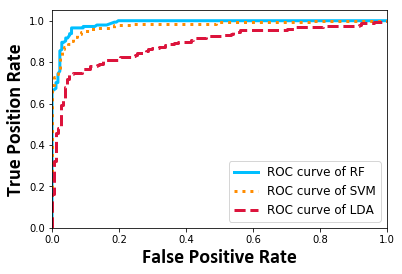

In [298]:
plt.figure()
plt.plot(fpr_BS_rf,tpr_BS_rf,'deepskyblue',label='ROC curve of RF',linewidth=3)
plt.plot(fpr_BS_svm,tpr_BS_svm,'darkorange',label='ROC curve of SVM',linewidth=3,linestyle=':')
plt.plot(fpr_BS_lda,tpr_BS_lda,'crimson',label='ROC curve of LDA',linewidth=3,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',**axis_font)
plt.ylabel('True Position Rate',**axis_font)
plt.legend(loc='lower right',fontsize=12)
plt.savefig('ROC_SMOTE_sampling',dpi=1200)
plt.show()

The 2nd test

In [51]:
X_train_BS_2, X_test_BS_2, y_train_BS_2, y_test_BS_2 = data_preparation_scheme(s_num=3)

BS_result_2, BS_lda_model_2, BS_lda_pred_val_2, BS_svm_model_2, BS_svm_pred_val_2, BS_rf_model_2, BS_rf_pred_val_2 = \
                                                train_models(X_train_BS_2, X_test_BS_2, y_train_BS_2,y_test_BS_2)

In [52]:
BS_result_2.set_index(["Method"], inplace=True)
BS_result_2

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.78165,0.79242,0.83226,0.75000,0.81944
SVM,0.92405,0.92393,0.94578,0.91279,0.93750
RF,0.93354,0.92868,0.93642,0.94186,0.92361


In [54]:
BS_rf_model_2.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_features': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

### Drop of the bottom 11 metric

In [170]:
def border_drop_scheme(random_seed):
    dfct = dfd[dfd["CrossedSignal"]==1].copy()
        
    newname = ["Depolarization_Power_Deposit_Mean","Diattenuation_Circ_Deposit_Std",
               "Q_metric_Deposit_Mean", "Q_metric_Deposit_Std",
               "Anisotropy_Lin_Deposit_Mean", "Anisotropy_Lin_Deposit_Std",
               "Anisotropy_Circ_Deposit_Std","Polarizance_Lin_Deposit_Mean", 
               "Polarizance_Lin_Deposit_Std","Retardance_Lin_Deposit_Mean", 
               "Retardance_Lin_Deposit_Std","Retardance_Circ_Deposit_Mean", 
               "A_metric_Deposit_Mean", "A_metric_Deposit_Std",
               "b_metric_Deposit_Mean","t_metric_Deposit_Mean", 
               "x_metric_Deposit_Mean", 
               "FluoroSignal", "CrossedSignal"]
    
    dfct = dfct[newname]
    
    metric_data = dfct.values[:,0:(dfct.shape[1]-2)]
    metric_label = dfct["FluoroSignal"].values
    
            
    BS = BorderlineSMOTE(random_state=42)
    [bs_data, bs_label] = BS.fit_resample(metric_data, metric_label)
    
    scaler = preprocessing.StandardScaler().fit(bs_data)
    bs_data_ = scaler.transform(bs_data)
        
    X_bs_train, X_bs_test, y_bs_train, y_bs_test = train_test_split(bs_data_, bs_label, test_size=0.2, random_state=random_seed)
    return X_bs_train, X_bs_test, y_bs_train, y_bs_test

In [171]:
X_train_bsdrop, X_test_bsdrop, y_train_bsdrop, y_test_bsdrop = border_drop_scheme()

In [172]:
X_train_bsdrop.shape

(1262, 17)

In [173]:
result_bsdrop, lda_model_bsdrop, lda_pred_val_bsdrop, svm_model_bsdrop, svm_pred_val_bsdrop, rf_model_bsdrop, rf_pred_val_bsdrop = \
                                                train_models(X_train_bsdrop, X_test_bsdrop, y_train_bsdrop,y_test_bsdrop)

In [174]:
result_bsdrop.set_index(["Method"], inplace=True)
result_bsdrop

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.79114,0.81063,0.85811,0.73837,0.85417
SVM,0.91772,0.90650,0.95062,0.89535,0.94444
RF,0.96835,0.94216,0.97093,0.97093,0.96528


### Using borderline-2

In [224]:
X_train_BS2, X_test_BS2, y_train_BS2, y_test_BS2 = data_preparation_scheme(s_num=3)

BS2_result_1, BS2_lda_model_1, BS2_lda_pred_val_1, BS2_svm_model_1, BS2_svm_pred_val_1, BS2_rf_model_1, BS2_rf_pred_val_1 = \
                                                train_models(X_train_BS2, X_test_BS2, y_train_BS2,y_test_BS2)

In [234]:
collections.Counter(np.append(y_train_BS2,y_test_BS2))

Counter({0: 789, 1: 789})

In [258]:
BS2_result_1.set_index(["Method"], inplace=True)
BS2_result_1

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.78165,0.79242,0.83226,0.75000,0.81944
SVM,0.91139,0.89382,0.86735,0.98837,0.81944
RF,0.91772,0.91204,0.92941,0.91860,0.91667


In [227]:
BS2_rf_model_1.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 8,
 'min_samples_split': 7,
 'n_estimators': 884}

In [228]:
feature_names = list(dfd.columns[0:-2].values)
feature_names_31 = feature_names[:28]

feature_importance_31 = BS2_rf_model_1.best_estimator_.feature_importances_
importance_table_31 = fimportance_dataframe(feature_names_31,feature_importance_31)

importance_table_31.set_index(["Metric"])

,Importance in percentage
Metric,
x_metric_Deposit_Mean,0.10581
Retardance_Lin_Deposit_Std,0.07888
Diattenuation_Circ_Deposit_Std,0.06648
Retardance_Lin_Deposit_Mean,0.06454
Retardance_Circ_Deposit_Mean,0.06064
Q_metric_Deposit_Std,0.04874
A_metric_Deposit_Std,0.04608
Anisotropy_Lin_Deposit_Mean,0.04341
Q_metric_Deposit_Mean,0.03647


## Without oversampling

In [141]:
X_train_, X_test_, y_train_, y_test_ = data_preparation_scheme(s_num=4)

result, lda_model, lda_pred_val, svm_model, svm_pred_val, rf_model, rf_pred_val = \
                                                train_models(X_train_, X_test_, y_train_,y_test_)

C:\Users\y63qiu\AppData\Local\Continuum\anaconda3\envs\yorkml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [267]:
result.set_index(["Method"], inplace=True)
result

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.91848,0.89543,0.91716,0.99359,0.50000
SVM,0.84783,0.86005,0.84783,1.00000,0.00000
RF,0.90761,0.91304,0.91124,0.98718,0.46429


In [268]:
rf_model.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_features': 6,
 'min_samples_split': 3,
 'n_estimators': 939}

In [269]:
BS_svm_model_1.best_params_

{'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': True}

In [270]:
feature_names = list(dfd.columns[0:-2].values)
feature_names_ = feature_names[:28]

feature_importance_ = rf_model.best_estimator_.feature_importances_
importance_table_ = fimportance_dataframe(feature_names_,feature_importance_)

importance_table_.set_index(["Metric"])

,Importance in percentage
Metric,
Diattenuation_Circ_Deposit_Std,0.09776
Polarizance_Lin_Deposit_Std,0.07419
Anisotropy_Lin_Deposit_Std,0.06771
Retardance_Lin_Deposit_Mean,0.06448
Polarizance_Circ_Deposit_Std,0.06302
x_metric_Deposit_Mean,0.05253
Retardance_Lin_Deposit_Std,0.05121
Retardance_Circ_Deposit_Std,0.03811
Anisotropy_Lin_Deposit_Mean,0.03539


The 2nd test

In [197]:
X2_train_, X2_test_, y2_train_, y2_test_ = data_preparation_scheme(s_num=4,random_seed=1)

result_2, lda_model_2, lda_pred_val_2, svm_model_2, svm_pred_val_2, rf_model_2, rf_pred_val_2 = \
                                                train_models(X2_train_, X2_test_, y2_train_,y2_test_)

C:\Users\y63qiu\AppData\Local\Continuum\anaconda3\envs\yorkml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [198]:
result_2.set_index(["Method"], inplace=True)
result_2

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.86413,0.91186,0.90625,0.93548,0.48276
SVM,0.84239,0.86141,0.84239,1.00000,0.00000
RF,0.84783,0.92391,0.88957,0.93548,0.37931


The 3rd test

In [199]:
X3_train_, X3_test_, y3_train_, y3_test_ = data_preparation_scheme(s_num=4,random_seed=10)

result_3, lda_model_3, lda_pred_val_3, svm_model_3, svm_pred_val_3, rf_model_3, rf_pred_val_3 = \
                                                train_models(X3_train_, X3_test_, y3_train_,y3_test_)

In [200]:
result_3.set_index(["Method"], inplace=True)
result_3

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.87500,0.90890,0.88554,0.97351,0.42424
SVM,0.82065,0.86685,0.82065,1.00000,0.00000
RF,0.87500,0.91440,0.87647,0.98675,0.36364


The 4th test

In [201]:
X4_train_, X4_test_, y4_train_, y4_test_ = data_preparation_scheme(s_num=4,random_seed=15)

result_4, lda_model_4, lda_pred_val_4, svm_model_4, svm_pred_val_4, rf_model_4, rf_pred_val_4 = \
                                                train_models(X4_train_, X4_test_, y4_train_,y4_test_)

In [202]:
result_4.set_index(["Method"], inplace=True)
result_4

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.90761,0.90213,0.93491,0.96341,0.45
SVM,0.89130,0.84918,0.89130,1.00000,0.00
RF,0.91848,0.90217,0.93567,0.97561,0.45


The 5th test

In [203]:
X5_train_, X5_test_, y5_train_, y5_test_ = data_preparation_scheme(s_num=4,random_seed=20)

result_5, lda_model_5, lda_pred_val_5, svm_model_5, svm_pred_val_5, rf_model_5, rf_pred_val_5 = \
                                                train_models(X5_train_, X5_test_, y5_train_,y5_test_)

In [204]:
result_5.set_index(["Method"], inplace=True)
result_5

,Accuracy,Mean accuracy,Precision,Sensitivity (Recall),Specificity
Method,,,,,
LDA,0.90217,0.89804,0.92727,0.96226,0.52
SVM,0.86413,0.85598,0.86413,1.00000,0.00
RF,0.89130,0.91304,0.91617,0.96226,0.44


### ROC curves 

In [271]:
rf_pred_prob = rf_model_2.predict_proba(X2_test_)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y2_test_, rf_pred_prob)
auc_rf = roc_auc_score(y2_test_,rf_pred_prob)
auc_rf

0.8531701890989989

In [300]:
rf_pred_prob = rf_model.predict_proba(X_test_)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_, rf_pred_prob)
auc_rf = roc_auc_score(y_test_,rf_pred_prob)
auc_rf

0.8935439560439561

In [272]:
rf_pred_prob = rf_model_3.predict_proba(X3_test_)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y3_test_, rf_pred_prob)
auc_rf = roc_auc_score(y3_test_,rf_pred_prob)
auc_rf

0.8681517158338351

In [273]:
rf_pred_prob = rf_model_4.predict_proba(X4_test_)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y4_test_, rf_pred_prob)
auc_rf = roc_auc_score(y4_test_,rf_pred_prob)
auc_rf

0.8978658536585367

In [274]:
rf_pred_prob = rf_model_5.predict_proba(X5_test_)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y5_test_, rf_pred_prob)
auc_rf = roc_auc_score(y5_test_,rf_pred_prob)
auc_rf

0.8847798742138365

In [154]:
fpr_rf.shape

(32,)

In [144]:
svm_pred_prob = svm_model.predict_proba(X_test_)[:,1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test_, svm_pred_prob)
auc_svm = roc_auc_score(y_test_,svm_pred_prob)
auc_svm

0.8630952380952381

In [275]:
svm_pred_prob = svm_model_2.predict_proba(X2_test_)[:,1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y2_test_, svm_pred_prob)
auc_svm = roc_auc_score(y2_test_,svm_pred_prob)
auc_svm

0.8382647385984426

In [276]:
svm_pred_prob = svm_model_3.predict_proba(X3_test_)[:,1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y3_test_, svm_pred_prob)
auc_svm = roc_auc_score(y3_test_,svm_pred_prob)
auc_svm

0.839855508729681

In [277]:
svm_pred_prob = svm_model_4.predict_proba(X4_test_)[:,1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y4_test_, svm_pred_prob)
auc_svm = roc_auc_score(y4_test_,svm_pred_prob)
auc_svm

0.8765243902439024

In [278]:
svm_pred_prob = svm_model_5.predict_proba(X5_test_)[:,1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y5_test_, svm_pred_prob)
auc_svm = roc_auc_score(y5_test_,svm_pred_prob)
auc_svm

0.8757232704402516

In [145]:
lda_pred_prob = lda_model.predict_proba(X_test_)[:,1]
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_test_, lda_pred_prob)
auc_lda = roc_auc_score(y_test_,lda_pred_prob)
auc_lda

0.8683608058608058

In [279]:
lda_pred_prob = lda_model_2.predict_proba(X2_test_)[:,1]
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y2_test_, lda_pred_prob)
auc_lda = roc_auc_score(y2_test_,lda_pred_prob)
auc_lda

0.8687430478309233

In [280]:
lda_pred_prob = lda_model_3.predict_proba(X3_test_)[:,1]
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y3_test_, lda_pred_prob)
auc_lda = roc_auc_score(y3_test_,lda_pred_prob)
auc_lda

0.8360425446518162

In [281]:
lda_pred_prob = lda_model_4.predict_proba(X4_test_)[:,1]
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y4_test_, lda_pred_prob)
auc_lda = roc_auc_score(y4_test_,lda_pred_prob)
auc_lda

0.8734756097560976

In [282]:
lda_pred_prob = lda_model_5.predict_proba(X5_test_)[:,1]
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y5_test_, lda_pred_prob)
auc_lda = roc_auc_score(y5_test_,lda_pred_prob)
auc_lda

0.8676729559748428

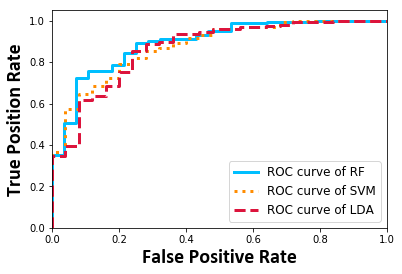

In [301]:
plt.figure()
plt.plot(fpr_rf,tpr_rf,'deepskyblue',label='ROC curve of RF',linewidth=3)
plt.plot(fpr_svm,tpr_svm,'darkorange',label='ROC curve of SVM',linewidth=3,linestyle=':')
plt.plot(fpr_lda,tpr_lda,'crimson',label='ROC curve of LDA',linewidth=3,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',**axis_font)
plt.ylabel('True Position Rate',**axis_font)
plt.legend(loc='lower right',fontsize=12)
plt.savefig('ROC_without_sampling',dpi=1200)
plt.show()